la dinamica della rete è descitta dall'equazione: tau*dx_i/dt=-x_i(t)+sum(J_ij*r_j(t))+sum(B_ik*u_k(t)) con r_j(t)=tanh(x_i(t))

In [23]:
import numpy as np
import random 
import matplotlib.pyplot as plt

Generation class trial

In [24]:
def trial(T=1500):
        
    u=np.zeros((T,2))
    
    #y=np.zeros(T)
  
    stim1=np.random.randint(0,2) # random number, either 0 or 1 -> 0=A 1=B
    stim2=np.random.randint(0,2) # random number, either 0 or 1

    ty=stim1+2*stim2                        #trial type: 0=AA, 1=BA, 2=AB, 3=BB

    ''' 
    if stim=0 (A) u1=1 and u2=0
    if stim=1 (B) u1=0 and u2=1
    '''
    
    u[:200,stim1]=1
    u[400:600,stim2]=1

    ''' 
    if identical inputs, output = -1
    if different inputs, output = 1
    '''
    
    #y[800:1000]=-1+2*np.mod(stim1+stim2,2)
    y=-1+2*np.mod(stim1+stim2,2)
    
    return u,y,ty


def generate_trials(n_trials,T=1500):

    U = np.zeros((n_trials,T,2))
    Y = np.zeros(n_trials)#,T))
    TY=np.zeros(n_trials)

    for n in range(n_trials):
        
        u,y,ty=trial()
        
        U[n,:,:]=u
        #Y[n,:]=y
        Y[n]=y
        TY[n]=ty

    return U,Y,TY
        

Constants and initialization

In [54]:
N=200           #numero neuroni
M=2             #numero input
tau=30          #tempo di rilassamento
g=1.5           #early chaotic
eta=0.5         #learning rate
alpha=0.33

dt=1.
T=1500
n_trials=1000
tottime=T*n_trials

b=dt/tau            #per semplicità definisco una nuova costante


J=np.zeros((N,N))
deltaJ=np.zeros((N,N))  
x=np.zeros((N,tottime))
x_ave=np.zeros(N)
r=np.zeros((N,tottime))
u=np.zeros((M,tottime))

E=np.zeros((N,N))#,tottime)) 

z=np.zeros(tottime)
B=np.zeros((N,M))

U,Y,TY = generate_trials(T=T,n_trials=n_trials)

R_ave=np.zeros(4)       #running average for each trial type
err=np.zeros(n_trials)

u=np.reshape(U,(n_trials*T,2)).T


In [55]:
J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)

x[:,0]=-0.1+0.2*np.random.rand(N)


Creating exploratory noise

In [42]:
noise= np.zeros((N,tottime))
rate=3./1000

for t in range(tottime):
     for i in range(N):
          if(np.random.rand()<rate):
               noise[i,t]=-0.5+1.*np.random.rand()
               
#print(noise[:,:5])                 #provo a contrarre gli indici, ma questo mi produce noise=0  

Fix biased neurons

In [28]:
n_fixed=4

fixed_neurons = np.random.choice(N,n_fixed,replace=False)

non_fixed_neurons = np.delete(np.arange(N),fixed_neurons)

reading_neuron = np.random.choice(non_fixed_neurons,1)
reading_neuron = reading_neuron[0]


x[fixed_neurons,:]=1


Training

In [56]:
for ntime in range(tottime-1):

    if (ntime<5):
        short_term=np.arange(ntime+1)
    else:
        short_term=np.arange(ntime-5, ntime+1, 1)       #indices from ntime-5 to ntime included 
        

    r[:,ntime]=np.tanh(x[:,ntime])
    x[:,ntime]+=noise[:,ntime]              
    
    sumJ=np.matmul(J,r[:,ntime])
        
    sumB=np.matmul(B,u[:,ntime])
    
    #x[non_fixed_neurons,ntime+1]=x[non_fixed_neurons,ntime]*(1-b)+\
    #b*sumB[non_fixed_neurons]+b*sumJ[non_fixed_neurons]      #ESPLICITO

    x[non_fixed_neurons,ntime+1]=x[non_fixed_neurons,ntime]/(1+b)+b/(1+b)*(sumJ[non_fixed_neurons]+sumB[non_fixed_neurons])       #IMPLICITO


    x_ave[:]=np.mean(x[:, short_term],axis=1)                   # short-term average on last 5 neuron activity

    E[:,...]+=pow((r[...,ntime]*(x[:,ntime+1]-x_ave[:]).T),3)     

   
    if(np.mod(ntime,T)==T-2):                       #ultimo time step di ciascun trial 
        curr_trial=ntime//T
        curr_ty=int(TY[curr_trial])           #trial type : 0=AA, 1=BA, 2=AB, 3=BB

        outp=np.mean(x[reading_neuron,(ntime-699):(ntime-499)]) #network output, mean over 200ms of response time
        err[curr_trial]=abs(Y[curr_trial]-outp)                             #network error = comparison between expected output and net output
        R=1-0.5*err[curr_trial]
        print(err[curr_trial])
        
        deltaJ=eta*(R-R_ave[curr_ty])*E
        J+=deltaJ
        R_ave[curr_ty]=alpha*R_ave[curr_ty]+(1-alpha)*R
        E=np.zeros((N,N))
        deltaJ=np.zeros((N,N)) 
        
       # z=x[reading_neuron,:]     




1.4778467930869055
0.5262132690175381
0.20129829483017958
1.535565329883413
0.5209391040944392
2.0153114697057974
0.08413896232453544
0.7214057881653566
4.228762205276458
0.8054222405134692
0.5140347538101151
1.5740920173057038
1.1373518974886998
1.8520516937208176
0.12751452515774764
1.1941024902362076
1.732586132198355
0.464740446282905
1.6607306850910546
1.2821395503047535
0.15738657849552218
2.1121274215249644
1.1454779823683157
1.2820661820941337
0.9021117755261584
1.647564803788021
1.820567654003626
0.036069376919231955
1.0364959456605658
0.583383935587724
1.8566047350178054
0.17796689838722446
0.3056849973911143
0.015432539810491197
0.9664487972177315
1.1728357579015187
1.3809368816556467
1.122554841721557
1.4094120799454923
0.2566902950791061
0.6557501722797152
0.6949780819583569
1.17175177122773
0.04711632285334699
0.41135381688778205
1.4541000731374905
1.8867876756213846
1.3571605115017087
0.2015836660667103
0.6397707799205437
0.4639121637285618
0.3454373094390213
0.567230787

KeyboardInterrupt: 

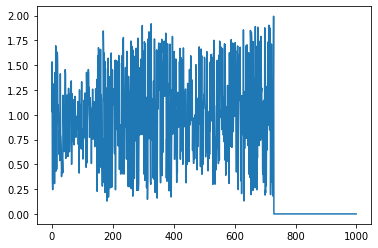

In [47]:
plt.plot(err)
plt.show()

Simulation dynamics already trained

In [ ]:
for ntime in range(tottime-1):


    r[:,ntime]=np.tanh(x[:,ntime])
    x[:,ntime]+=noise[:,ntime]              
    
    sumJ=np.matmul(J,r[:,ntime])
        
    sumB=np.matmul(B,u[:,ntime])
    
    x[non_fixed_neurons,ntime+1]=x[non_fixed_neurons,ntime]*(1-b)+\
    b*sumB[non_fixed_neurons]+b*sumJ[non_fixed_neurons]      #ESPLICITO

    #   x[:,ntime+1]=x[:,ntime]/(1+b)+b/(1+b)*(sumJ+sumB)       #IMPLICITO


z=x[reading_neuron,:]               #output  



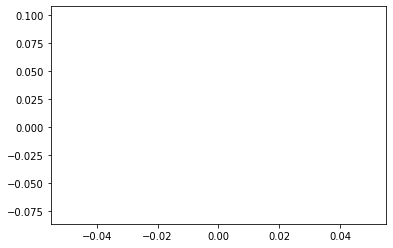

In [ ]:
plt.plot(x[:10,:].T)
plt.show()

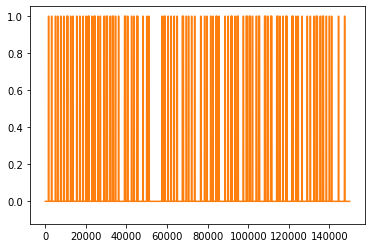

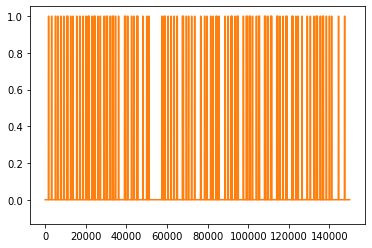

In [ ]:
idx_max_input1 = np.argmax(B[:,0])

plt.plot(x[idx_max_input1,:])
plt.plot(u[0,:])

plt.figure()
plt.plot(x[idx_max_input1+1,:])
plt.plot(u[0,:])

In [ ]:
from scipy.stats import pearsonr

corr_input1 = np.zeros(N)
corr_input2 = np.zeros(N)

for i in range(N):
    corr_input1[i],p=pearsonr(u[0,:],x[i,:])
    corr_input2[i],p=pearsonr(u[1,:],x[i,:])
    
plt.figure()
plt.scatter(B[:,0],corr_input1)

plt.figure()
plt.scatter(B[:,1],corr_input2)

ValueError: array must not contain infs or NaNs